# GeoTif Training
- Pick index for tring
- Convert the nasa data to lable tif

## Pending Issue:
- coarser  points data 375m than the nicfi 5meter
- If dropping the points data outside the target area, may lost something correct data if not dropping the data, model will be biased learning from the building area, it's Inaccurate, may overfitting based on the more noise data.
- Current plan is to drop the points data outside the target area, and then clip the points data to the target area. also have buffer area to get 100 meter area of the dumpsite.

## Preparing the data 
- target index list
- check the data count for each index
- check the shapefile
- show the nasa points on map



In [14]:
index_list=[581,1806,1212,1189,438,489,782]

tif_folder_path='tif'
tif_label_folder_path='tif_label'

#  clip the original points data to reduce total amount only 100 meter buffer of the dumpsite shapefile
J1V_shapefile_path='nasa_data/fire_nrt_J1VC2_536460_clip.shp'

Target_DP_shapefile_path='Target_DP_shape/c1212_ADRSM_T.shp'

In [15]:
import os

def check_tif_data(index_list,tif_path):
    # count the tif file number for files start with index
    for index in index_list:
        tif_file_list=os.listdir(tif_path)
        tif_file_list=[file for file in tif_file_list if file.startswith(str(index))]
        print(f'index {index} has {len(tif_file_list)} tif files')

check_tif_data(index_list,tif_folder_path)


index 581 has 42 tif files
index 1806 has 42 tif files
index 1212 has 42 tif files
index 1189 has 42 tif files
index 438 has 42 tif files
index 489 has 42 tif files
index 782 has 42 tif files


In [3]:
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
import leafmap
import geopandas as gpd

def show_tif_image_rgb(source_type, file_path):
    if source_type == 'nicfi':
        # read the tif file
        tif_file = rasterio.open(file_path)
        
        # read RGB bands
        blue = tif_file.read(1).astype(float)
        green = tif_file.read(2).astype(float)
        red = tif_file.read(3).astype(float)
        
        def normalize_nicfi(band):
            # Clip values to GEE visualization range
            band = np.clip(band, 64, 5454)  # Match GEE min/max values
            # Normalize to 0-1 range based on the visualization parameters
            band = (band - 64) / (5454 - 64)
            return band
        
        red = normalize_nicfi(red)
        green = normalize_nicfi(green)
        blue = normalize_nicfi(blue)
        
        # stack bands into RGB image
        rgb = np.dstack((red, green, blue))
        
        # Apply gamma correction matching GEE
        gamma = 1.8  # Same gamma as GEE
        rgb = np.power(rgb, 1/gamma)
        
        # get filename for title
        title = os.path.basename(file_path)
        
        # display image
        plt.figure(figsize=(4,4))
        plt.imshow(rgb)
        plt.title(title)
        plt.axis('off')
        plt.show()


def display_shapefile_on_map(shapefile_path):
    """
    Loads a shapefile and displays it on an interactive map.

    Parameters:
    shapefile_path (str): The file path to the shapefile.

    Returns:
    leafmap.Map: An interactive map with the shapefile overlay.
    """
    # Load the shapefile as a GeoDataFrame
    gdf = gpd.read_file(shapefile_path)
    
    red_style = {
        'color': 'red',  # outline color
        'fillOpacity': 0.1,  # transparency of fill
        'weight': 2  # line thickness
    }
    # Calculate the centroid for map centering
    map_center = [gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()]
    
    # Create an interactive map centered on the shapefile area
    m = leafmap.Map(center=map_center, zoom=10)
    
    # Get the filename without extension to use as layer name
    layer_name = os.path.splitext(os.path.basename(shapefile_path))[0]
    
    # Add the shapefile as a layer with filename as layer name
    m.add_gdf(gdf, layer_name=layer_name, style=red_style)

    # Add the shapefile as a layer
    m.add_gdf(gdf, layer_name="Shapefile Layer",style=red_style)
    
    # Optionally, add a satellite basemap
    m.add_basemap("SATELLITE")

    return m


def add_shape_file_on_map(map_object,shapefile_path):
        # Add the shapefile to the map
    layer_name= os.path.splitext(os.path.basename(shapefile_path))[0]
        # Load the shapefile as a GeoDataFrame
    gdf = gpd.read_file(shapefile_path)
    
    # Add the GeoDataFrame to the map
    map_object.add_gdf(gdf, layer_name=layer_name)
    
    return map_object

In [ ]:
# show the each image from the index list
for index in index_list:
    file_path=os.path.join(tif_folder_path,f'{index}-2021-04-nicfi.tif')
    show_tif_image_rgb('nicfi',file_path)



In [4]:
# show the dumpsite and fire oints 

map_object = display_shapefile_on_map(Target_DP_shapefile_path)
map_object=add_shape_file_on_map(map_object,J1V_shapefile_path)
map_object

Map(center=[-10.914215450970215, -75.32548261768909], controls=(ZoomControl(options=['position', 'zoom_in_text…

## Rasterize  the points data and binary data preparing

In [231]:
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.features import rasterize
from shapely.geometry import box
import pandas as pd


def create_binary_raster(tif_path, points_shpfile_path, buffer_radius=0.001,verbos=False):
    """
    Creates a binary raster layer from points that fall within the TIF extent
    and match the time period of the TIF file.
    
    Parameters:
        tif_path: path to TIF file (format: 'xxxxx-YYYY-MM-nicfi.tif')
        points_shpfile_path: path to points shapefile with ACQ_TIME field
        buffer_radius: radius in meters for buffering points in the UTM CRS 100 is meter, but currently the WGS84 is degree,  0.001 degree is about 100 meter
    """
    # Extract date from TIF filename
    tif_filename = os.path.basename(tif_path)
    try:
        # Parse YYYY-MM from filename
        tif_year = int(tif_filename.split('-')[1])
        tif_month = int(tif_filename.split('-')[2])
    except (IndexError, ValueError) as e:
        raise ValueError(f"Invalid TIF filename format. Expected 'xxxxx-YYYY-MM-nicfi.tif', got {tif_filename}")

    # Load the GeoTIFF to get metadata
    with rasterio.open(tif_path) as src:
        meta = src.meta.copy()
        transform = src.transform
        width = src.width
        height = src.height

        bounds = rasterio.windows.bounds(
            rasterio.windows.Window(0, 0, width, height), 
            transform
        )
        tif_boundary = box(*bounds)
    
    
    # Load the points shapefile
    points_gdf = gpd.read_file(points_shpfile_path)
    
#==========================Filtering the points data==========================
    # Ensure the points are in the same CRS as the TIF
    if points_gdf.crs != meta['crs']:
        print('The points shapefile crs is not the same as the TIF file crs, converting the points shapefile crs to the TIF file crs')
        points_gdf = points_gdf.to_crs(meta['crs'])
    
    # Convert ACQ_DATE to datetime and filter by year and month
    points_gdf['ACQ_DATE'] = pd.to_datetime(points_gdf['ACQ_DATE'])
    if verbos:
        print(f"Total points before date filtering: {len(points_gdf)}")
    points_gdf = points_gdf[
        (points_gdf['ACQ_DATE'].dt.year == tif_year) & 
        (points_gdf['ACQ_DATE'].dt.month == tif_month)
    ]
    if verbos:
        print(f"Points after date filtering: {len(points_gdf)}")
    
    # Filter points to only those within the TIF boundary
    points_gdf = points_gdf[points_gdf.geometry.intersects(tif_boundary)]
    if verbos:
        print(f"Final points after spatial filtering: {len(points_gdf)}")

    
    
    # If no points found within boundary and time period, return empty raster
    if len(points_gdf) == 0:
        return np.zeros((height, width), dtype='uint8'), meta
    

    # =====================buffer the points data==================================
    if verbos:
        print("\nBefore buffering:")
        print(f"Type of points_gdf: {type(points_gdf)}")
        print(f"CRS: {points_gdf.crs}")
        print(f'tif meta crs is {meta["crs"]}')
        print(f"Number of points: {len(points_gdf)}")
    if points_gdf.crs != meta['crs']:
        print('The points_gdf crs is not the same as the tif meta crs, converting the points_gdf crs to the tif meta crs')
        points_gdf = points_gdf.to_crs(meta['crs'])



# TODO CRS changeing to accepte the meters as unit of radius

    points_gdf['geometry'] = points_gdf.geometry.buffer(buffer_radius)

    # Print information after buffering
    if verbos:
        print("\nAfter buffering:")
        print(f"Number of features: {len(points_gdf)}")
        print(f"Geometry types: {points_gdf.geometry.geom_type.unique()}")
        print(f"Total area: {points_gdf.geometry.area.sum():.2f}")
        print(f'the center of the points_gdf is {points_gdf.geometry.centroid.x.mean()},{points_gdf.geometry.centroid.y.mean()}')
        print(f'the center of the tif boundary is {tif_boundary.centroid.x},{tif_boundary.centroid.y}')
    # Check for valid geometries
        print(f"Valid geometries: {points_gdf.geometry.is_valid.sum()}/{len(points_gdf)}")


    #  check after buffering the points data, if there are any overlaps , buffer will be merged into one
    if verbos:
            # Handle both single polygon and multipolygon cases
        union_geom = points_gdf.geometry.unary_union
        if hasattr(union_geom, 'geoms'):
            num_geometries = len(union_geom.geoms)
        else:
            # If it's a single polygon, count as 1
            num_geometries = 1
        print(f"After buffering {len(points_gdf)} points, there are {num_geometries} distinct geometries due to overlaps")

    if verbos:
            # Convert tif_boundary to UTM or another suitable projected CRS for accurate area calculation
            tif_boundary_gdf = gpd.GeoDataFrame(geometry=[tif_boundary], crs=meta['crs'])
            # Convert to a suitable UTM zone for accurate area measurement
            utm_zone = int((bounds[0] + 180) // 6) + 1
            utm_crs = f'EPSG:326{utm_zone}' if bounds[1] >= 0 else f'EPSG:327{utm_zone}'
            tif_boundary_utm = tif_boundary_gdf.to_crs(utm_crs)
            tif_boundary_area = tif_boundary_utm.geometry.area[0]
            
            print(f'TIF boundary area is {tif_boundary_area:.2f} square meters')
            print(f'{len(points_gdf)} points found within boundary and time period')
            buffer_area = points_gdf.geometry.area.sum()
            print(f'Points buffer area is {buffer_area:.2f} square meters')
            print(f'Buffer area is {(buffer_area/tif_boundary_area)*100:.2f}% of TIF area')

            # check the buffer and the tif boundary geometry is overlap or not
            if points_gdf.geometry.intersects(tif_boundary).all():
                print('Points buffer area is within TIF boundary')
            else:
                print('Points buffer area is outside TIF boundary')


    shapes = [(geom, 1) for geom in points_gdf.geometry if not geom.is_empty]
    

    # Rasterize shapes onto the binary_array with a value of 1 for overlap areas
    binary_array = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,  # areas outside overlap_shape will remain 0
        dtype='uint8'
    )



    if verbos:
        print(f'The binary array shape is {binary_array.shape}')
        # count the number of 1 in the binary array
        print(f'The number of 1 in the binary array is {np.count_nonzero(binary_array)}')




    # Update meta information to reflect the single-band, binary raster

    meta.update({"count": 1, "dtype": 'uint8'})

    return binary_array, meta



def show_value_distribution(binary_layer):
    # show the value distribution of the binary layer
    plt.hist(binary_layer.flatten(), bins=256, range=(0, 1), density=True, alpha=0.75)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title('Value Distribution of the Binary Layer')
    plt.show()


def show_binary_layer(binary_layer, title="Binary Layer"):
    """
    Display the binary raster layer.
    
    Parameters:
        binary_layer: numpy array of the binary raster
        title: title for the plot
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(binary_layer, cmap=plt.cm.colors.ListedColormap(['black', 'red']))  # Use discrete colors for 0 and 1
    cbar = plt.colorbar(ticks=[0, 1], label='Binary Value')
    cbar.ax.set_yticklabels(['black (0)', 'red (1)'])  # Custom labels showing colors and values
    plt.title(title)
    plt.axis('off')
    plt.show()

def save_layer_as_tif(binary_layer,meta,file_name):
    file_path=os.path.join(tif_label_folder_path,file_name)
    with rasterio.open(file_path, 'w', **meta) as dst:
        dst.write(binary_layer, 1)
        print(f'The binary layer is saved to {file_path}')




Total points before date filtering: 623
Points after date filtering: 16
Final points after spatial filtering: 2

Before buffering:
Type of points_gdf: <class 'geopandas.geodataframe.GeoDataFrame'>
CRS: EPSG:4326
tif meta crs is GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
Number of points: 2

After buffering:
Number of features: 2
Geometry types: ['Polygon']
Total area: 0.00
the center of the points_gdf is -76.68749000041316,-12.510110000026431
the center of the tif boundary is -76.68856944246676,-12.510095851823177
Valid geometries: 2/2
After buffering 2 points, there are 1 distinct geometries due to overlaps
TIF boundary area is 167120.93 square meters
2 points found within boundary and time period
Points buffer area is 0.00 square meters
Buffer area is 0.00% of TIF area
Points buffer area is within TIF boundar

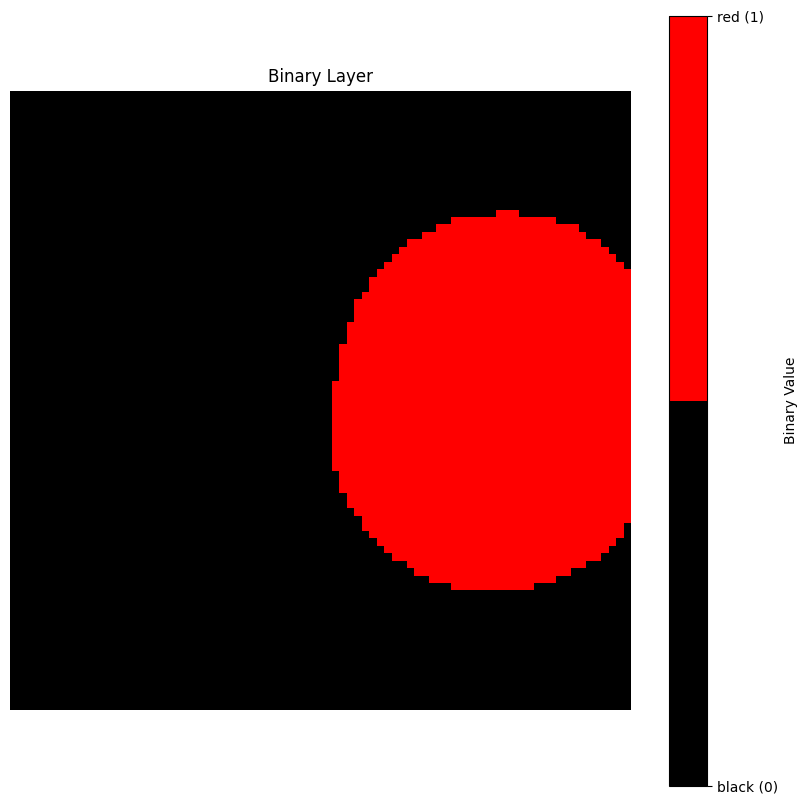

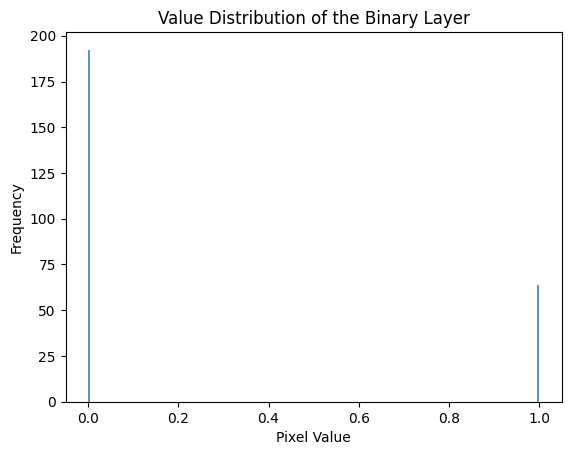

In [233]:
# Try example of convert firepoints to raster data
example_tif_file_name='438-2021-05-nicfi.tif'
fire_layer,meta=create_binary_raster(f"{tif_folder_path}\{example_tif_file_name}",J1V_shapefile_path,verbos=True)
show_binary_layer(fire_layer)
# print the meta data


show_value_distribution(fire_layer)
layer_name=f"{example_tif_file_name.split('.')[0]}-l.tif"
save_layer_as_tif(fire_layer,meta,layer_name)


In [ ]:
## Perform the data convert 


### Method 1: Tabluar 
- Combine the original tif file and the binary fire label tif file to extract the tabular data
- all the data will be saved in the csv file


- Table head include:
    - ImageIndex: the index of the tif file
    - Date: the date of the tif file
    - PixelIndex: the index of the pixel
    - Latitude: the latitude of the pixel
    - Longitude: the longitude of the pixel
    - Band1-4: the value of the band 1-4 in the tif file
    - Fire_binary: the binary of the fire label


| ImageIndex | Date | PixelIndex | Latitude | Longitude | Band1 | Band2 | Band3 | Band4 | Fire_binary |
|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|
| int      | str      | int      | float    | float    | float  | float  | float  | float  | int      |


In [4]:
tif_folder_path_mac='tif'
tif_label_folder_path_mac='tif_label'
example_tif_file_name='438-2021-05-nicfi.tif'
example_tif_label_name='438-2021-05-nicfi-l.tif'
csvfile_name="example.csv"

csvfile_path_mac="csv"





In [5]:
import rasterio
import pandas as pd
import numpy as np
import os





# Function to extract band values and construct a DataFrame with pixel indices and geographic info
def extract_bands_with_index_and_geo_info(tif1_path, tif2_path,validate=False):
    # Parse file names to extract index and date information
    def parse_filename(filename):
        basename = os.path.basename(filename)
        parts = basename.split('-')
        index, date = parts[0], '-'.join(parts[1:3])
        return index, date
    
    # Open the first GeoTIFF file and extract its bands and geographic info
    with rasterio.open(tif1_path) as tif1:
        # Assume tif1 has 4 bands
        bands_tif1 = [tif1.read(i + 1).flatten() for i in range(4)]
        
        # Generate the latitude and longitude for each pixel
        coords = [tif1.transform * (x, y) for y in range(tif1.height) for x in range(tif1.width)]
        longitudes, latitudes = zip(*coords)  # Unzip into separate lists
        
        # Generate a pixel index from left to right, top to bottom
        pixel_indices = range(1, tif1.width * tif1.height + 1)
    
    # Open the second GeoTIFF file and extract its single band
    with rasterio.open(tif2_path) as tif2:
        # Assume tif2 has 1 band, and it matches tif1's dimensions
        band_tif2 = tif2.read(1).flatten()
    
    # Extract metadata from filenames
    tif1_index, tif1_date = parse_filename(tif1_path)
    
    # Create DataFrame with extracted data
    df = pd.DataFrame({
        'ImageIndex': tif1_index,
        'Date': tif1_date,
        'PixelIndex': pixel_indices,
        'Latitude': latitudes,
        'Longitude': longitudes,
        'Band1': bands_tif1[0],
        'Band2': bands_tif1[1],
        'Band3': bands_tif1[2],
        'Band4': bands_tif1[3],
        'Fire_binary': band_tif2
    })

    if validate:
        # percentage of the fire in the tif file
        fire_percentage=np.count_nonzero(band_tif2)/len(band_tif2)
        print(f'The fire percentage in the tif file is {fire_percentage*100:.2f}%')
        # percentage of the fire in df's fire_binary column
        fire_binary_percentage=np.count_nonzero(df['Fire_binary'])/len(df['Fire_binary'])
        print(f'The fire percentage in df\'s fire_binary column is {fire_binary_percentage*100:.2f}%')

        # count of rows in df
        print(f'The number of rows in df is {len(df)}')
        # count of pixels in tif1
        print(f'The number of pixels in tif1 is {tif1.width*tif1.height}')
        # size of tif1 and tif2 , 
    
    return df


def save_table_as_csv(df,file_name):
    file_path=os.path.join(csvfile_path_mac,file_name)
    df.to_csv(file_path,index=False)
    print(f'The table is saved to {file_path}')


In [6]:
#example running ,
df = extract_bands_with_index_and_geo_info(f'{tif_folder_path_mac}/{example_tif_file_name}',f'{tif_label_folder_path_mac}/{example_tif_label_name}',validate=True)
save_table_as_csv(df,csvfile_name)


The fire percentage in the tif file is 24.85%
The fire percentage in df's fire_binary column is 24.85%
The number of rows in df is 6889
The number of pixels in tif1 is 6889
The table is saved to csv\example.csv


#### Basic csv and normalized the bands data , preparing the data

In [7]:
# csv of file

csv_file_name="example.csv"
csv_file_path="csv/"
csv_file=csv_file_path+csv_file_path

Dataset Information:
Total rows: 6889
Columns: ['ImageIndex', 'Date', 'PixelIndex', 'Latitude', 'Longitude', 'Band1', 'Band2', 'Band3', 'Band4', 'Fire_binary']

Data types:
ImageIndex       int64
Date            object
PixelIndex       int64
Latitude       float64
Longitude      float64
Band1          float64
Band2          float64
Band3          float64
Band4          float64
Fire_binary      int64
dtype: object

Summary Statistics:
       ImageIndex   PixelIndex     Latitude    Longitude        Band1  \
count      6889.0  6889.000000  6889.000000  6889.000000  6889.000000   
mean        438.0  3445.000000   -12.510073   -76.688592   925.672667   
std           0.0  1988.827335     0.001076     0.001076    79.756301   
min         438.0     1.000000   -12.511915   -76.690433   683.000000   
25%         438.0  1723.000000   -12.511017   -76.689535   881.000000   
50%         438.0  3445.000000   -12.510073   -76.688592   937.000000   
75%         438.0  5167.000000   -12.509130   -76.6

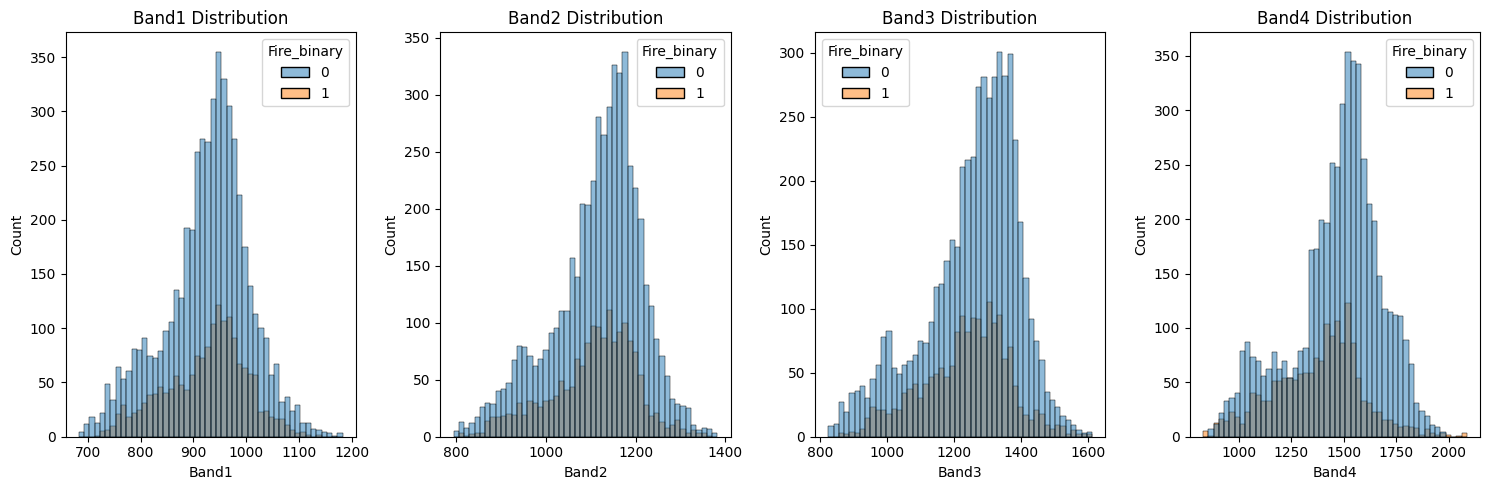

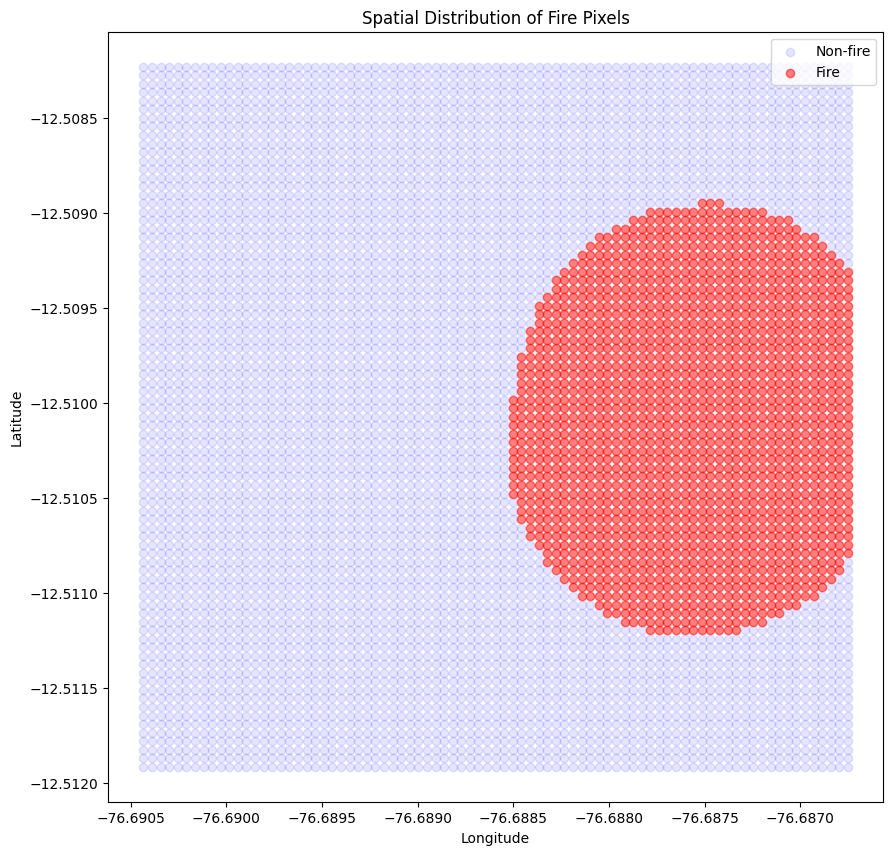

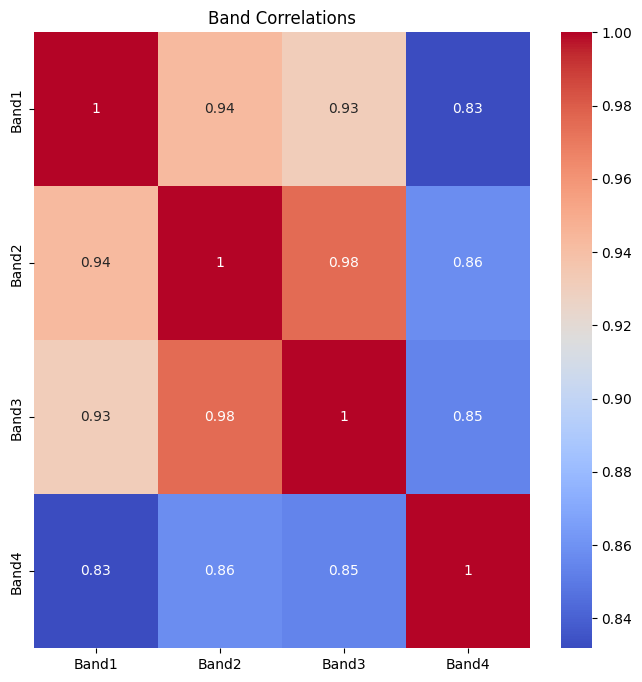


Band Statistics by Fire Classification:

Band1:
Fire pixels:
count    1712.000000
mean      924.553738
std        76.664804
min       720.000000
25%       872.000000
50%       937.000000
75%       975.000000
max      1142.000000
Name: Band1, dtype: float64

Non-fire pixels:
count    5177.000000
mean      926.042689
std        80.756412
min       683.000000
25%       884.000000
50%       937.000000
75%       976.000000
max      1183.000000
Name: Band1, dtype: float64

Band2:
Fire pixels:
count    1712.000000
mean     1105.291472
std        96.805606
min       812.000000
25%      1048.000000
50%      1118.500000
75%      1172.250000
max      1365.000000
Name: Band2, dtype: float64

Non-fire pixels:
count    5177.000000
mean     1115.439251
std        99.520358
min       795.000000
25%      1062.000000
50%      1133.000000
75%      1181.000000
max      1382.000000
Name: Band2, dtype: float64

Band3:
Fire pixels:
count    1712.000000
mean     1235.086449
std       130.336653
min       869

In [1]:
# check the max and min of the colum of bands in the csv 

# read the csv to pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def read_and_analyze_csv(csv_path):
    """
    Read and analyze the CSV file containing the image data
    
    Parameters:
    csv_path (str): Path to the CSV file
    
    Returns:
    pd.DataFrame: The loaded DataFrame
    """
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    # Print basic information
    print("Dataset Information:")
    print(f"Total rows: {len(df)}")
    print(f"Columns: {df.columns.tolist()}")
    print("\nData types:")
    print(df.dtypes)
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print(df.describe())
    
    # Count fire pixels
    fire_count = df['Fire_binary'].sum()
    total_pixels = len(df)
    print(f"\nFire Statistics:")
    print(f"Fire pixels: {fire_count}")
    print(f"Total pixels: {total_pixels}")
    print(f"Fire percentage: {(fire_count/total_pixels)*100:.2f}%")
    
    # Visualize band distributions
    plt.figure(figsize=(15, 5))
    for i, band in enumerate(['Band1', 'Band2', 'Band3', 'Band4'], 1):
        plt.subplot(1, 4, i)
        sns.histplot(data=df, x=band, hue='Fire_binary', bins=50)
        plt.title(f'{band} Distribution')
    plt.tight_layout()
    plt.show()
    
    return df

# Example usage:
csv_file = "csv/example.csv"
df = read_and_analyze_csv(csv_file)

# Additional analysis functions
def analyze_spatial_distribution(df):
    """Analyze spatial distribution of fire pixels"""
    plt.figure(figsize=(10, 10))
    plt.scatter(df[df['Fire_binary']==0]['Longitude'], 
               df[df['Fire_binary']==0]['Latitude'], 
               c='blue', alpha=0.1, label='Non-fire')
    plt.scatter(df[df['Fire_binary']==1]['Longitude'], 
               df[df['Fire_binary']==1]['Latitude'], 
               c='red', alpha=0.5, label='Fire')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Spatial Distribution of Fire Pixels')
    plt.legend()
    plt.show()

def analyze_band_correlations(df):
    """Analyze correlations between bands"""
    bands = ['Band1', 'Band2', 'Band3', 'Band4']
    corr = df[bands].corr()
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Band Correlations')
    plt.show()

# Run additional analyses
analyze_spatial_distribution(df)
analyze_band_correlations(df)

# Print band statistics by fire/non-fire
print("\nBand Statistics by Fire Classification:")
for band in ['Band1', 'Band2', 'Band3', 'Band4']:
    print(f"\n{band}:")
    print("Fire pixels:")
    print(df[df['Fire_binary']==1][band].describe())
    print("\nNon-fire pixels:")
    print(df[df['Fire_binary']==0][band].describe())

Point Biserial Correlation:
Band1:
  Correlation: -0.0081
  P-value: 5.0314e-01

Band2:
  Correlation: -0.0443
  P-value: 2.3310e-04

Band3:
  Correlation: -0.0590
  P-value: 9.3871e-07

Band4:
  Correlation: -0.1831
  P-value: 5.5255e-53



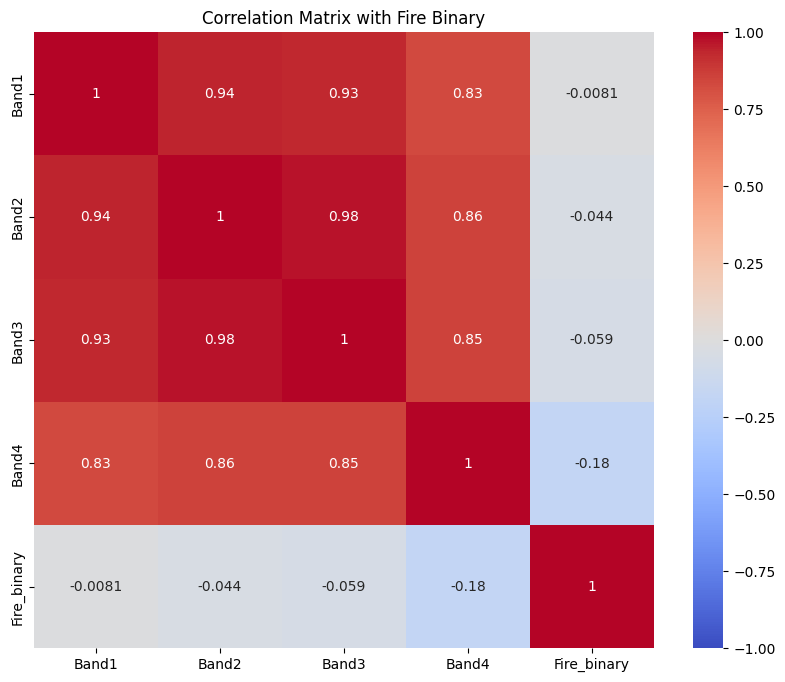


Mutual Information Scores:
Band1: 0.0024
Band2: 0.0026
Band3: 0.0094
Band4: 0.0263


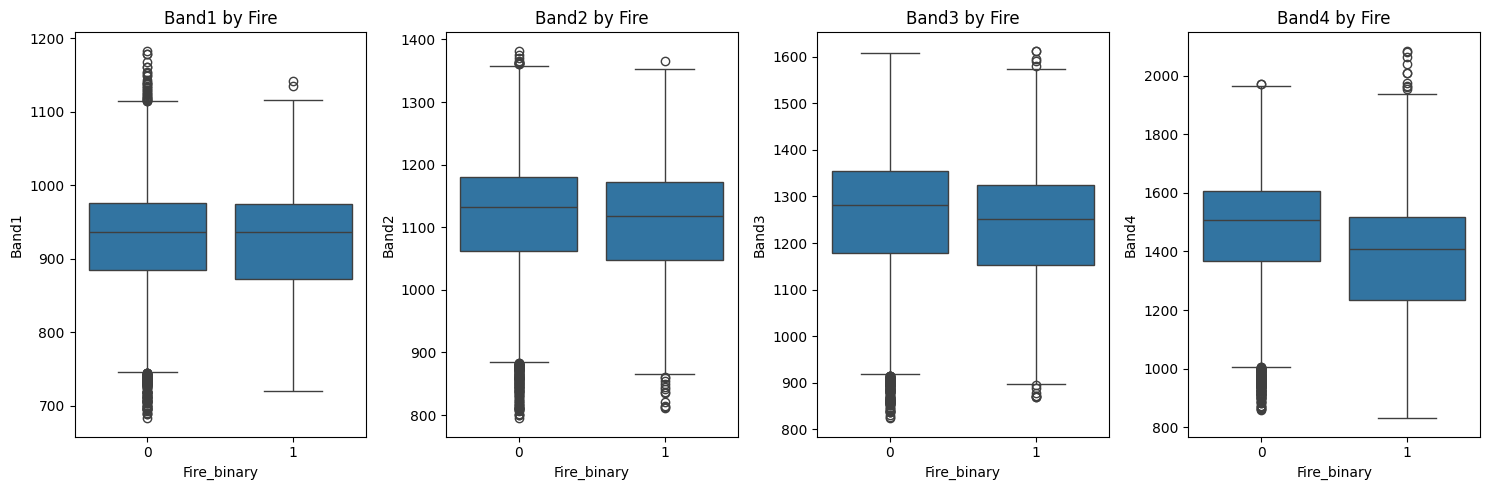


Band Ratios Analysis:
NDVI:
  Correlation: -0.2700
  P-value: 2.3839e-115
GNDVI:
  Correlation: -0.2682
  P-value: 7.8078e-114


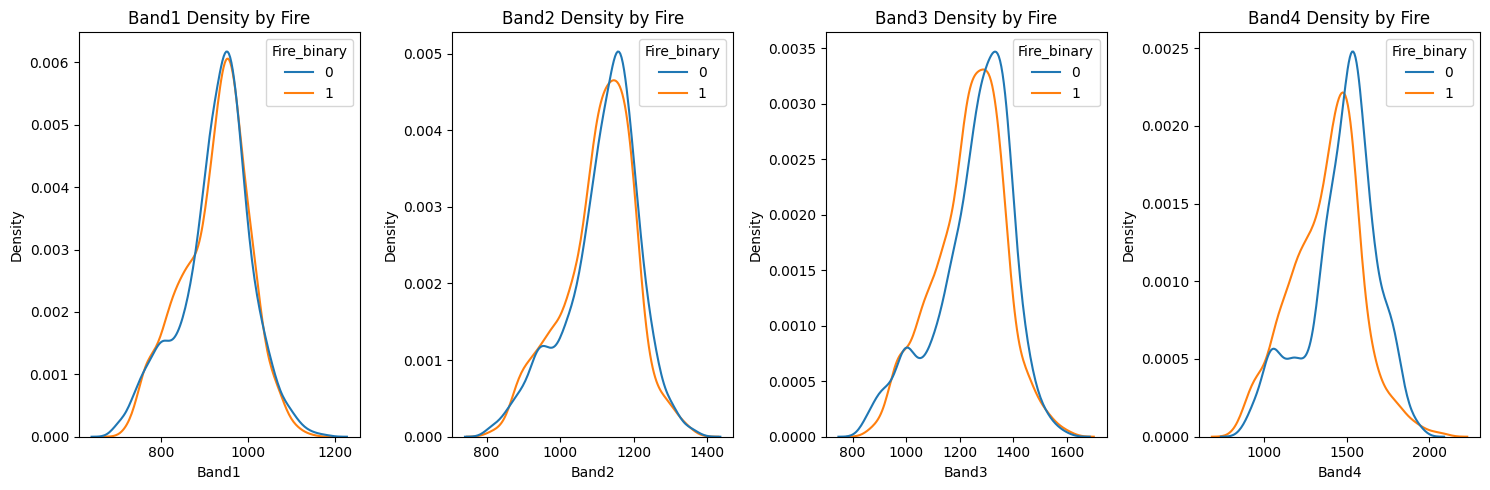


Statistical Tests:

Band1 Mann-Whitney U test:
  Statistic: 4387119.5000
  P-value: 5.3375e-01

Band2 Mann-Whitney U test:
  Statistic: 4112696.0000
  P-value: 7.8502e-06

Band3 Mann-Whitney U test:
  Statistic: 3900011.5000
  P-value: 9.2873e-14

Band4 Mann-Whitney U test:
  Statistic: 3203743.5000
  P-value: 2.1946e-66


<Figure size 1200x1200 with 0 Axes>

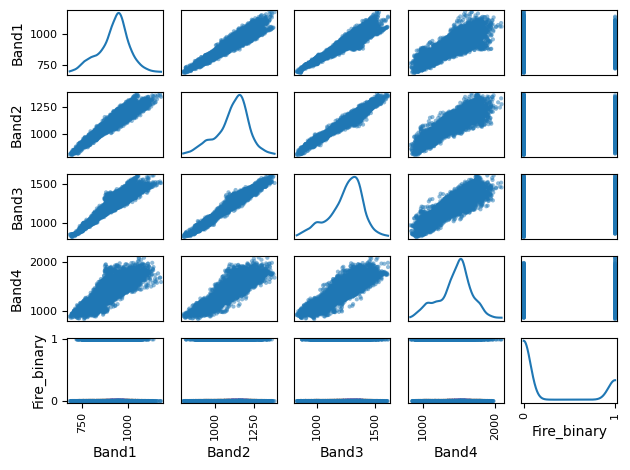


Strongest correlations with Fire_binary:
Band1   -0.008068
Band2   -0.044325
Band3   -0.059044
Band4   -0.183063
Name: Fire_binary, dtype: float64


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr, chi2_contingency
from sklearn.metrics import mutual_info_score

def analyze_band_fire_correlations(df):
    """
    Comprehensive correlation analysis between bands and fire_binary
    """
    bands = ['Band1', 'Band2', 'Band3', 'Band4']
    
    # 1. Point Biserial Correlation (for binary and continuous variables)
    print("Point Biserial Correlation:")
    for band in bands:
        correlation, pvalue = pointbiserialr(df['Fire_binary'], df[band])
        print(f"{band}:")
        print(f"  Correlation: {correlation:.4f}")
        print(f"  P-value: {pvalue:.4e}")
        print()

    # 2. Create correlation matrix including Fire_binary
    corr_matrix = df[bands + ['Fire_binary']].corr()
    
    # Visualize correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix with Fire Binary')
    plt.show()

    # 3. Mutual Information Score (captures non-linear relationships)
    print("\nMutual Information Scores:")
    for band in bands:
        mi_score = mutual_info_score(df['Fire_binary'], 
                                   pd.qcut(df[band], q=10, duplicates='drop'))
        print(f"{band}: {mi_score:.4f}")

    # 4. Box plots for each band by fire/non-fire
    plt.figure(figsize=(15, 5))
    for i, band in enumerate(bands, 1):
        plt.subplot(1, 4, i)
        sns.boxplot(x='Fire_binary', y=band, data=df)
        plt.title(f'{band} by Fire')
    plt.tight_layout()
    plt.show()

    # 5. Band ratios analysis
    print("\nBand Ratios Analysis:")
    # Create common vegetation indices
    df['NDVI'] = (df['Band4'] - df['Band3']) / (df['Band4'] + df['Band3'])
    df['GNDVI'] = (df['Band4'] - df['Band2']) / (df['Band4'] + df['Band2'])
    
    for index in ['NDVI', 'GNDVI']:
        correlation, pvalue = pointbiserialr(df['Fire_binary'], df[index])
        print(f"{index}:")
        print(f"  Correlation: {correlation:.4f}")
        print(f"  P-value: {pvalue:.4e}")

    # 6. Density plots
    plt.figure(figsize=(15, 5))
    for i, band in enumerate(bands, 1):
        plt.subplot(1, 4, i)
        sns.kdeplot(data=df, x=band, hue='Fire_binary', common_norm=False)
        plt.title(f'{band} Density by Fire')
    plt.tight_layout()
    plt.show()

    # 7. Statistical tests for each band
    print("\nStatistical Tests:")
    for band in bands:
        # Mann-Whitney U test (non-parametric)
        from scipy.stats import mannwhitneyu
        stat, p_value = mannwhitneyu(df[df['Fire_binary']==1][band],
                                   df[df['Fire_binary']==0][band])
        print(f"\n{band} Mann-Whitney U test:")
        print(f"  Statistic: {stat:.4f}")
        print(f"  P-value: {p_value:.4e}")

    return corr_matrix

# Run the analysis
csv_file = "csv/example.csv"
df = pd.read_csv(csv_file)
correlations = analyze_band_fire_correlations(df)

# Additional visualization: Scatter matrix
plt.figure(figsize=(12, 12))
pd.plotting.scatter_matrix(df[['Band1', 'Band2', 'Band3', 'Band4', 'Fire_binary']], 
                         diagonal='kde')
plt.tight_layout()
plt.show()

# Print summary of strongest correlations
print("\nStrongest correlations with Fire_binary:")
fire_correlations = correlations['Fire_binary'].drop('Fire_binary').sort_values(ascending=False)
print(fire_correlations)

Data Statistics:

Raw Data:
             Band1        Band2        Band3        Band4
count  6889.000000  6889.000000  6889.000000  6889.000000
mean    925.672667  1112.917405  1249.390913  1448.114095
std      79.756301    98.942938   139.327772   215.495626
min     683.000000   795.000000   824.000000   831.000000
25%     881.000000  1060.000000  1172.000000  1334.000000
50%     937.000000  1130.000000  1274.000000  1483.000000
75%     976.000000  1179.000000  1347.000000  1584.000000
max    1183.000000  1382.000000  1613.000000  2085.000000

Standardized Data:
       Band1_standard  Band2_standard  Band3_standard  Band4_standard
count    6.889000e+03    6.889000e+03    6.889000e+03    6.889000e+03
mean    -7.096145e-16    5.115825e-16   -2.805453e-16    1.980319e-16
std      1.000073e+00    1.000073e+00    1.000073e+00    1.000073e+00
min     -3.042898e+00   -3.213372e+00   -3.053388e+00   -2.863904e+00
25%     -5.601552e-01   -5.348663e-01   -5.554997e-01   -5.295809e-01
50%      1

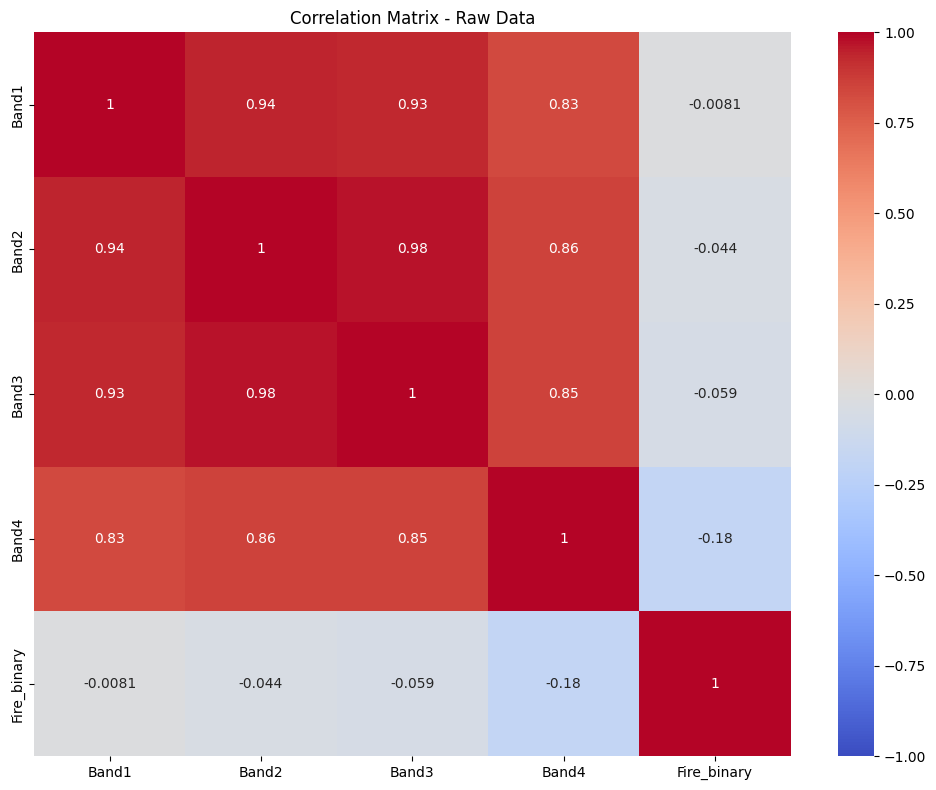

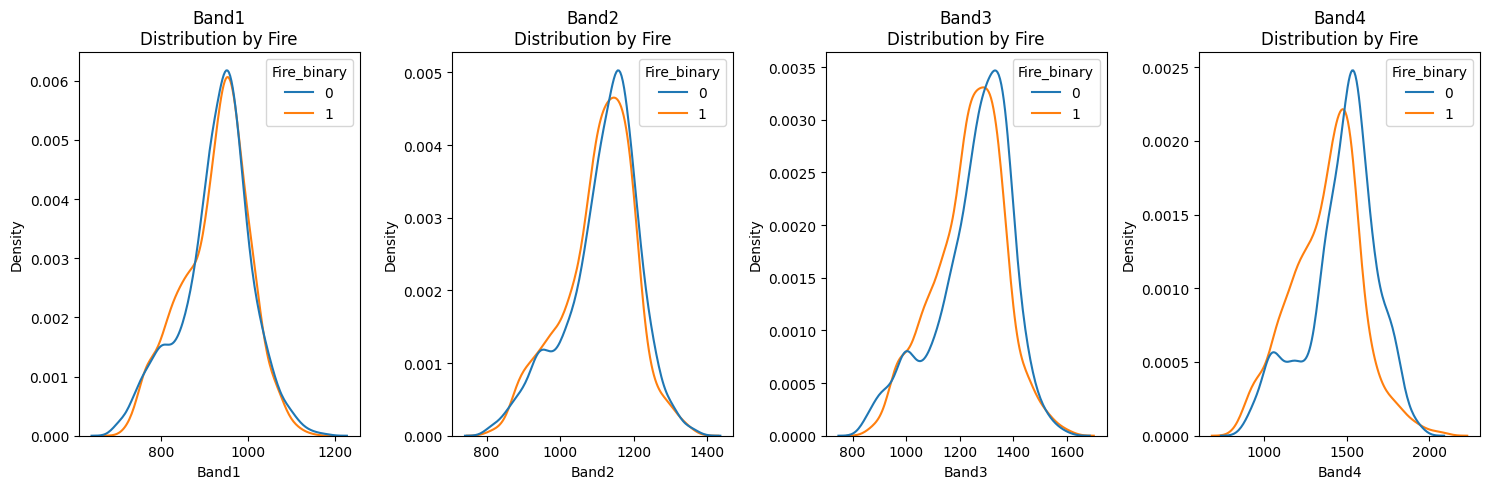


Standardized Data Correlations:

Point Biserial Correlation:
Band1_standard:
  Correlation: -0.0081
  P-value: 5.0314e-01
Band2_standard:
  Correlation: -0.0443
  P-value: 2.3310e-04
Band3_standard:
  Correlation: -0.0590
  P-value: 9.3871e-07
Band4_standard:
  Correlation: -0.1831
  P-value: 5.5255e-53


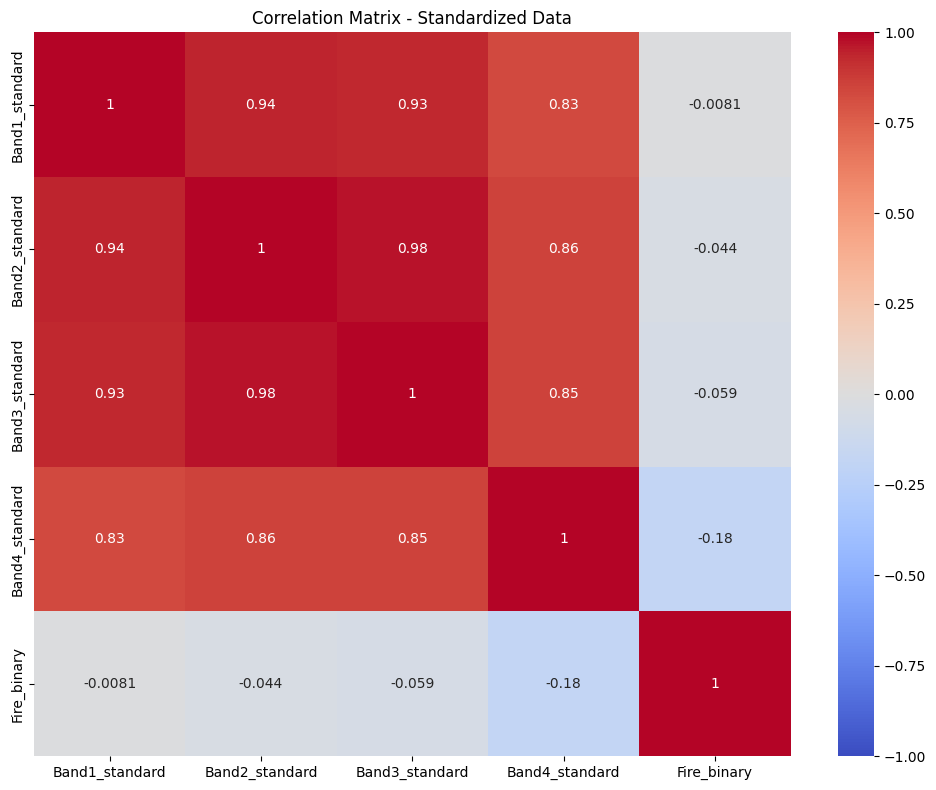

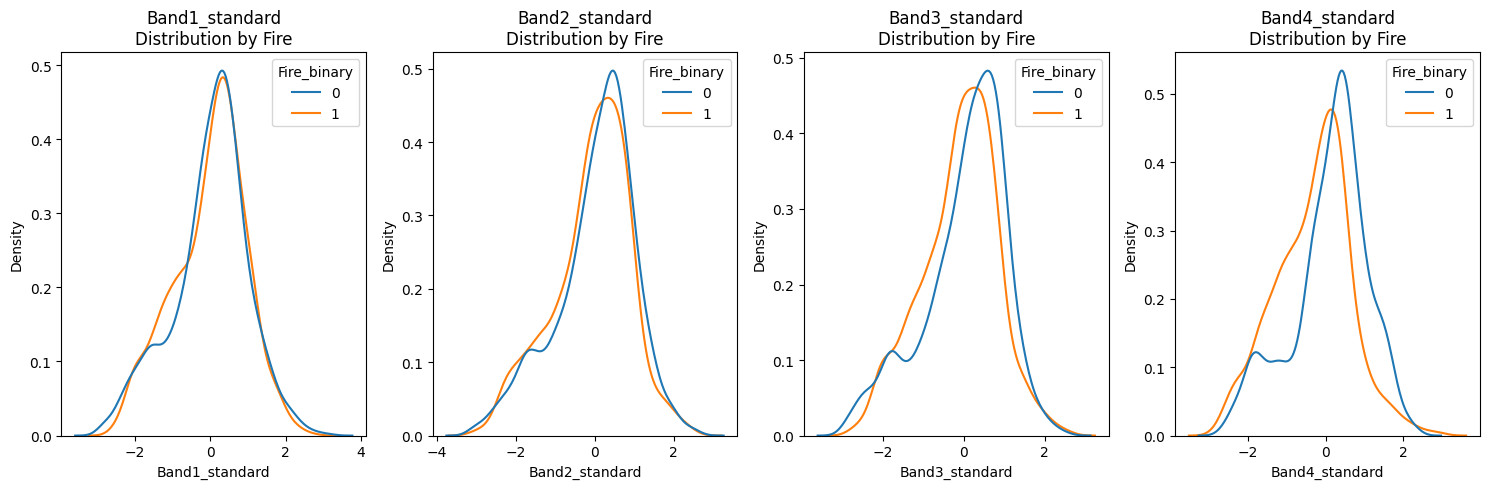


MinMax Data Correlations:

Point Biserial Correlation:
Band1_minmax:
  Correlation: -0.0081
  P-value: 5.0314e-01
Band2_minmax:
  Correlation: -0.0443
  P-value: 2.3310e-04
Band3_minmax:
  Correlation: -0.0590
  P-value: 9.3871e-07
Band4_minmax:
  Correlation: -0.1831
  P-value: 5.5255e-53


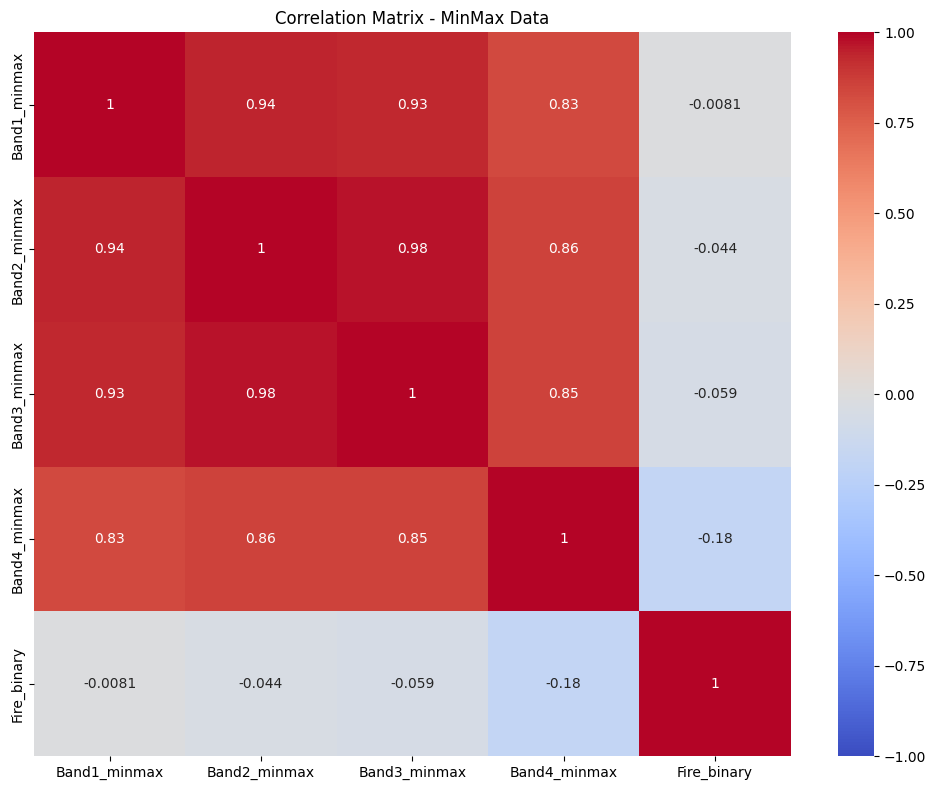

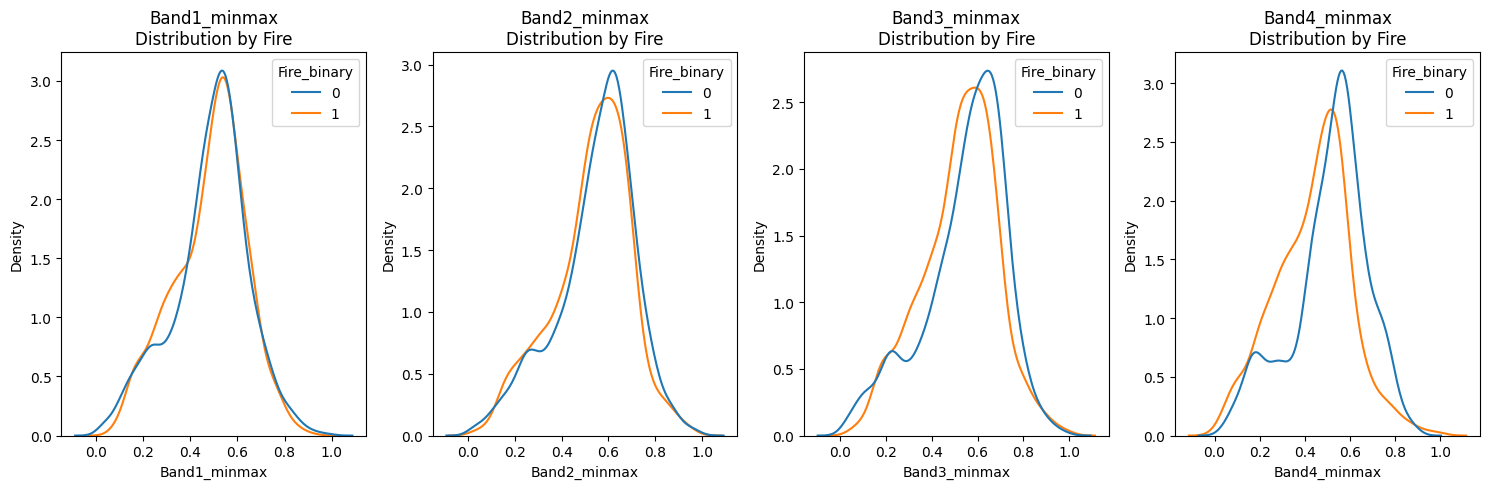

<Figure size 1200x600 with 0 Axes>

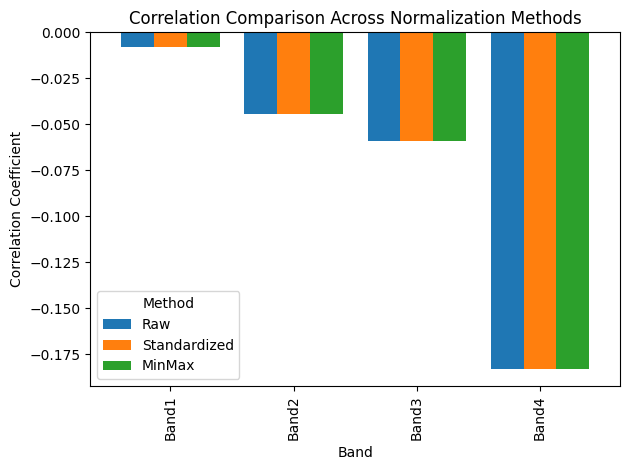


Correlation Comparison:
    Band       Raw  Standardized    MinMax
0  Band1 -0.008068     -0.008068 -0.008068
1  Band2 -0.044325     -0.044325 -0.044325
2  Band3 -0.059044     -0.059044 -0.059044
3  Band4 -0.183063     -0.183063 -0.183063


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def normalize_and_analyze_correlations(df):
    """
    Analyze correlations with both raw and normalized data
    """
    bands = ['Band1', 'Band2', 'Band3', 'Band4']
    
    # Create normalized versions using different methods
    # 1. StandardScaler (Z-score normalization)
    scaler_standard = StandardScaler()
    df_standard = pd.DataFrame(
        scaler_standard.fit_transform(df[bands]),
        columns=[f"{b}_standard" for b in bands]
    )
    
    # 2. MinMaxScaler (0-1 normalization)
    scaler_minmax = MinMaxScaler()
    df_minmax = pd.DataFrame(
        scaler_minmax.fit_transform(df[bands]),
        columns=[f"{b}_minmax" for b in bands]
    )
    
    # Combine all versions with fire binary
    df_combined = pd.concat([
        df[bands], 
        df_standard, 
        df_minmax, 
        df['Fire_binary']
    ], axis=1)
    
    # Print basic statistics
    print("Data Statistics:")
    print("\nRaw Data:")
    print(df[bands].describe())
    print("\nStandardized Data:")
    print(df_standard.describe())
    print("\nMinMax Normalized Data:")
    print(df_minmax.describe())
    
    # Correlation analysis for each version
    methods = {
        'Raw': bands,
        'Standardized': [f"{b}_standard" for b in bands],
        'MinMax': [f"{b}_minmax" for b in bands]
    }
    
    for method_name, columns in methods.items():
        print(f"\n{method_name} Data Correlations:")
        
        # Point Biserial Correlation
        print("\nPoint Biserial Correlation:")
        for col in columns:
            correlation, pvalue = pointbiserialr(df_combined['Fire_binary'], 
                                               df_combined[col])
            print(f"{col}:")
            print(f"  Correlation: {correlation:.4f}")
            print(f"  P-value: {pvalue:.4e}")
        
        # Visualize correlations
        plt.figure(figsize=(10, 8))
        corr_matrix = df_combined[columns + ['Fire_binary']].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title(f'Correlation Matrix - {method_name} Data')
        plt.tight_layout()
        plt.show()
        
        # Distribution plots
        plt.figure(figsize=(15, 5))
        for i, col in enumerate(columns, 1):
            plt.subplot(1, 4, i)
            sns.kdeplot(data=df_combined, x=col, hue='Fire_binary', common_norm=False)
            plt.title(f'{col}\nDistribution by Fire')
        plt.tight_layout()
        plt.show()
    
    return df_combined

# Load and analyze data
csv_file = "csv/example.csv"
df = pd.read_csv(csv_file)
df_analyzed = normalize_and_analyze_correlations(df)

# Compare correlation differences
def compare_correlation_methods(df_analyzed):
    """Compare how correlations change with different normalizations"""
    bands = ['Band1', 'Band2', 'Band3', 'Band4']
    
    results = []
    for band in bands:
        raw_corr, _ = pointbiserialr(df_analyzed['Fire_binary'], 
                                    df_analyzed[band])
        std_corr, _ = pointbiserialr(df_analyzed['Fire_binary'], 
                                    df_analyzed[f"{band}_standard"])
        minmax_corr, _ = pointbiserialr(df_analyzed['Fire_binary'], 
                                       df_analyzed[f"{band}_minmax"])
        
        results.append({
            'Band': band,
            'Raw': raw_corr,
            'Standardized': std_corr,
            'MinMax': minmax_corr
        })
    
    comparison_df = pd.DataFrame(results)
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    comparison_df.set_index('Band').plot(kind='bar', width=0.8)
    plt.title('Correlation Comparison Across Normalization Methods')
    plt.ylabel('Correlation Coefficient')
    plt.legend(title='Method')
    plt.tight_layout()
    plt.show()
    
    return comparison_df

comparison = compare_correlation_methods(df_analyzed)
print("\nCorrelation Comparison:")
print(comparison)

### Tabluar Model 1 - Logistic Regression

In [17]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time

# Load your data (example: df = pd.read_csv('your_data.csv'))
# Prepare data
def prepare_data(df, features, target):
    X = df[features].values
    y = df[target].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test, scaler



# Logistic Regression model class
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

class EnhancedLogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(EnhancedLogisticRegressionModel, self).__init__()
        # Add multiple layers with different dimensions
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.relu(self.layer3(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.output(x))
        return x
    
# Random Forest model class
class RandomForestModel(nn.Module):
    def __init__(self, input_dim, n_estimators=100, max_depth=10):
        super(RandomForestModel, self).__init__()
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        
        # Create multiple decision trees (estimators)
        self.trees = nn.ModuleList([
            DecisionTreeModule(input_dim, max_depth) 
            for _ in range(n_estimators)
        ])
        
    def forward(self, x):
        # Get predictions from all trees
        tree_preds = torch.stack([tree(x) for tree in self.trees])
        
        # Average predictions (majority voting)
        ensemble_pred = torch.mean(tree_preds, dim=0)
        return torch.sigmoid(ensemble_pred)

# Helper Decision Tree Module        
class DecisionTreeModule(nn.Module):
    def __init__(self, input_dim, max_depth):
        super(DecisionTreeModule, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
        
    def forward(self, x):
        return self.layers(x)



def measure_mode(model, X_train, y_train, X_test, y_test, lr=0.01, num_epochs=100):
    # Train the model and get results
    metrics = train_and_evaluate(model, X_train, y_train, X_test, y_test, lr, num_epochs)
    
    # Plot training metrics over epochs
    plt.figure(figsize=(12, 6))
    plt.plot(metrics['train_losses'], label='Training Loss')
    plt.plot(metrics['val_losses'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.legend()
    plt.show()
    
    # Plot metrics comparison
    plt.figure(figsize=(12, 6))
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
    values = [metrics[m] for m in metrics_to_plot]
    plt.bar(metrics_to_plot, values)
    plt.ylim(0, 1)
    plt.title('Model Performance Metrics')
    plt.ylabel('Score')
    plt.show()
    
    # Print detailed metrics
    print("\nModel Performance Metrics:")
    print(f"Final Training Loss: {metrics['train_losses'][-1]:.4f}")
    print(f"Final Validation Loss: {metrics['val_losses'][-1]:.4f}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"ROC AUC: {metrics['roc_auc']:.4f}")
    
    return metrics

# Train and evaluate function
def train_and_evaluate(model, X_train, y_train, X_test, y_test, lr=0.01, num_epochs=100):
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
    
    # Convert data to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    # Split training data into train and validation
    train_size = int(0.8 * len(X_train_tensor))
    X_train_final = X_train_tensor[:train_size]
    y_train_final = y_train_tensor[:train_size]
    X_val = X_train_tensor[train_size:]
    y_val = y_train_tensor[train_size:]

    # Loss and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        outputs = model(X_train_final)
        train_loss = criterion(outputs, y_train_final)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_losses.append(val_loss.item())

    # Final evaluation
    model.eval()
    with torch.no_grad():
        y_pred_proba = model(X_test_tensor)
        y_pred = y_pred_proba.round()
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred.numpy())
        precision = precision_score(y_test, y_pred.numpy())
        recall = recall_score(y_test, y_pred.numpy())
        f1 = f1_score(y_test, y_pred.numpy())
        roc_auc = roc_auc_score(y_test, y_pred_proba.numpy())

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

# Plot function for comparison
def plot_comparison(results):
    import numpy as np
    
    # Training loss comparison
    plt.figure(figsize=(12, 6))
    for model_name, result in results.items():
        plt.plot(result['train_losses'], label=f"{model_name} Train Loss")
        plt.plot(result['val_losses'], label=f"{model_name} Val Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Comparison')
    plt.legend()
    plt.show()

    # Metrics comparison
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    plt.figure(figsize=(12, 6))
    x = np.arange(len(metrics))
    width = 0.8 / len(results)
    
    for i, (model_name, result) in enumerate(results.items()):
        values = [result[metric] for metric in metrics]
        plt.bar(x + i * width, values, width, label=model_name)
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x + width * (len(results) - 1) / 2, metrics)
    plt.legend()
    plt.show()

# Main function to load data, train models, and plot results
def main():
    # Define features and target
    features = ['Band1', 'Band2', 'Band3', 'Band4']
    target = 'Fire_binary'
    
    # Load and prepare data
    X_train, X_test, y_train, y_test, _ = prepare_data(df, features, target)

    # Initialize models and results storage
    models = {
        "Simple Logistic Regression": LogisticRegressionModel(input_dim=len(features)),
        "Enhanced Logistic Regression": EnhancedLogisticRegressionModel(input_dim=len(features)),
        "Random Forest": RandomForestModel(input_dim=len(features))
    }
    results = {}

    # Train and evaluate each model
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        start_time = time.time()
        metrics = train_and_evaluate(model, X_train, y_train, X_test, y_test)
        training_time = time.time() - start_time
        metrics['training_time'] = training_time
        results[model_name] = metrics
        
        print(f"\n{model_name} Performance:")
        print(f"Training Time: {training_time:.2f} seconds")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {metrics['f1']:.4f}")
        print(f"ROC AUC: {metrics['roc_auc']:.4f}")

    # Plot comparison
    plot_comparison(results)





Training Simple Logistic Regression...

Simple Logistic Regression Performance:
Accuracy: 0.7569
Precision: 0.5362
Recall: 0.1088
F1 Score: 0.1809
ROC AUC: 0.7345

Training Enhanced Logistic Regression...

Enhanced Logistic Regression Performance:
Accuracy: 0.7925
Precision: 0.6552
Recall: 0.3353
F1 Score: 0.4436
ROC AUC: 0.8037

Training Random Forest...

Random Forest Performance:
Accuracy: 0.7939
Precision: 0.6458
Recall: 0.3647
F1 Score: 0.4662
ROC AUC: 0.8291


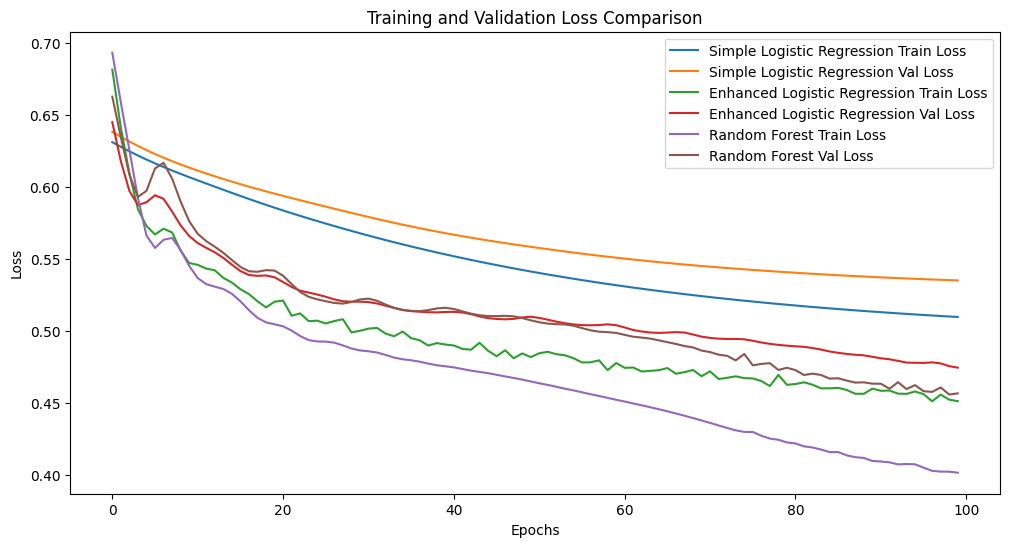

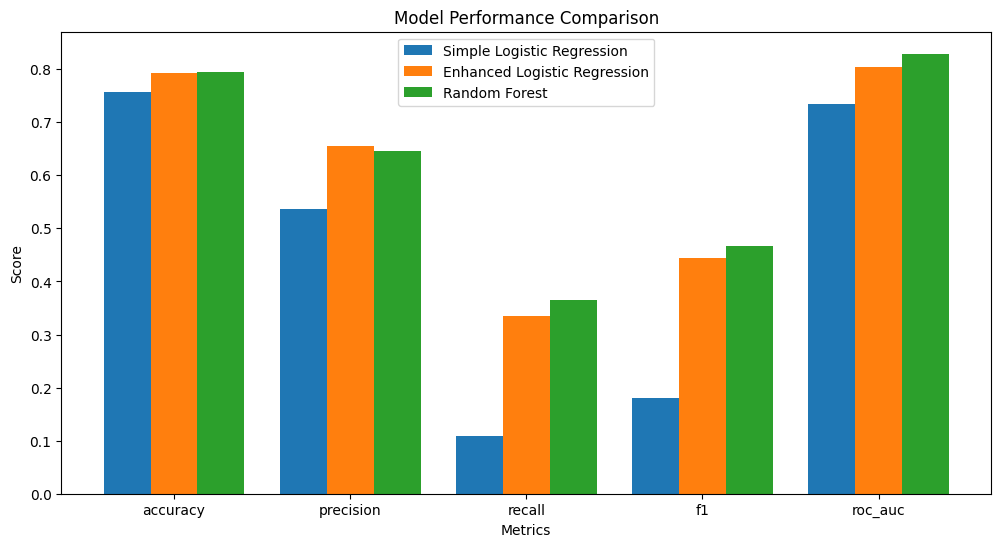

In [18]:
# Run the main function
main()